# 0. Preliminaries

In [1]:
import json
import random
import os
from PIL import Image
from itertools import product
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from collections import Counter

from domain import SYM2PROG, Program
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../semantics/dreamcoder")

from jointer import AST

In [2]:
symbol_images_dir = 'symbol_images/'
splits = ['train', 'val', 'test']
max_value_train = 100
max_value_test = 10000

min_num = 0
max_num = 10
num_list = list(map(str, range(min_num, max_num)))
nonzero_num_list = [x for x in num_list if x != '0']
op_list = ['+', '-', '*', '/']
lps = '('
rps = ')'

print(num_list)
print(op_list, lps, rps)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['+', '-', '*', '/'] ( )


In [3]:
def render_img(img_paths):
    images = [Image.open(symbol_images_dir + x) for x in img_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return new_im

# 1. Split handwritten symbols

In [4]:
# split train and test set of math symbols
random.seed(777)
terminals = ['+', '-', 'times', 'div', '(', ')', '!'] + list(map(str, list(range(10)))) + ['alpha', 'beta', 'gamma', 'theta', 'phi'] + list('abcde')
sym_train_set = {}
sym_val_set = {}
sym_test_set = {}
for tok in terminals:
    imgs = os.listdir(symbol_images_dir + tok)
    random.shuffle(imgs)
    n_train = int(len(imgs) * 0.75)
    n_val = int(len(imgs) * 0.05)
    sym_train_set[tok] = sorted(imgs[:n_train])
    sym_val_set[tok] = sorted(imgs[n_train:n_train+n_val])
    sym_test_set[tok] = sorted(imgs[n_train+n_val:])
    print(tok, len(imgs))
json.dump(sym_train_set, open('sym_train.json', 'w'))
json.dump(sym_val_set, open('sym_val.json', 'w'))
json.dump(sym_test_set, open('sym_test.json', 'w'))

+ 5443
- 6022
times 600
div 157
( 3986
) 3978
! 224
0 1810
1 6327
2 6210
3 2469
4 1641
5 1008
6 812
7 753
8 731
9 742
alpha 383
beta 295
gamma 90
theta 543
phi 83
a 2724
b 1830
c 1194
d 1062
e 616


# 2. Generate expressions

In [5]:
random.seed(777)
class Iterator:
    def __init__(self, l, shuffle=True):
        if shuffle: 
            random.shuffle(l)
        self.list = l
        self.current = -1
        self.shuffle = shuffle
    
    def next(self):
        self.current += 1
        if self.current == len(self.list):
            self.current = 0
            if self.shuffle:
                random.shuffle(self.list)
        return self.list[self.current]

tok_convert = {'*': 'times', '/': 'div', 'a': 'alpha', 'b': 'beta', 'c': 'gamma', 'd': 'phi', 'e': 'theta'}
def generate_img_paths(tokens, sym_set):
    img_paths = []
    for tok in tokens:
        if tok in tok_convert:
            tok = tok_convert[tok]
        
        img_name = sym_set[tok].next()
        img_paths.append(os.path.join(tok, img_name))   
        
    return img_paths

split2sym = {}
for split in splits:
    sym_set = {k:Iterator(v) for k,v in json.load(open('sym_%s.json'%split)).items()}
    split2sym[split] = sym_set

In [6]:
op2precedence = {'+': 2, '-': 2, '*': 3, '/': 3, '!': 4}
op2arity = {'+': 2, '-': 2, '*': 2, '/': 2, '!': 1}

def parse_infix(expr):
    values = []
    operators = []
    
    head = [-1] * len(expr)
    for (i,sym) in enumerate(expr):
        if sym.isdigit():
            values.append(i)
        elif sym == lps:
            operators.append(i)
        elif sym == rps:
            while expr[operators[-1]] != lps:
                op = operators.pop()
                for _ in range(op2arity[expr[op]]):
                    head[values.pop()] = op
                values.append(op)
            i_lps = operators[-1]
            i_rps = i
            head[i_lps] = op
            head[i_rps] = op
            operators.pop()
        else:
            while len(operators) > 0 and expr[operators[-1]] != lps and \
                op2precedence[expr[operators[-1]]] >= op2precedence[sym]:
                op = operators.pop()
                for _ in range(op2arity[expr[op]]):
                    head[values.pop()] = op
                values.append(op)
            operators.append(i)

    while len(operators) > 0:
        op = operators.pop()
        for _ in range(op2arity[expr[op]]):
            head[values.pop()] = op
        values.append(op)

    root_op = values.pop()
    head[root_op] = -1
    assert len(values) == 0

    return head

def parse_prefix(expr):
    head = [-1] * len(expr)
    arity = [op2arity.get(x, 0) for x in expr]
    for i in range(len(expr)):
        if i == 0: 
            head[i] = -1
            continue
        for j in range(i-1, -1, -1):
            if arity[j] > 0:
                break
        head[i] = j
        arity[j] -= 1
        #print(i, head, arity)

    return head

def flatten(expr):
    if len(expr) == 1:
        return expr
    return [y for x in expr for y in flatten(x)]

def prefix2infix(prefix):
    prefix = list(prefix)
    values = []
    while len(prefix) > 0:
        sym = prefix.pop()
        if sym.isdigit():
            values.append([sym])
        else:
            arity = op2arity[sym]
            precedence = op2precedence[sym]
            
            left = values.pop()
            right = values.pop() if arity == 2 else []
            """
            add parenthesis when:
            (1) left is a compound expression and its operator's precedence < the current operator
            (2) right is a compound expression and its operator's precedence <= the current operator
            here we assume that the operator is left-associative.
            """
            if len(left) > 1 and op2precedence[left[1]] < precedence:
                left = [lps] + left + [rps]
            if len(right) > 1 and op2precedence[right[1]] <= precedence:
                right = [lps] + right + [rps]
                
            new_value = [left, sym, right]
            values.append(new_value)
    
    infix = ''.join(flatten(values.pop()))
    assert len(values) == 0
    return infix

from collections import namedtuple
Parse = namedtuple('Parse', 'sentence head')
def eval_expr(expr, head):
    ast = AST(Parse(expr, head), SYM2PROG)
    return ast.res(), ast.res_all()
    
def eval_expr_by_eval(expr):
    expr_for_eval = []
    for symbol in expr:
        if symbol == '!':
            expr_for_eval[-1] = 'math.factorial(' + expr_for_eval[-1] + ')'
        elif symbol == '/':
            expr_for_eval.append('//')
        else:
            expr_for_eval.append(symbol)
#     try:
#         res = eval("".join(expr_for_eval))
#     except OverflowError:
#         res = None
    res = eval("".join(expr_for_eval))
    return res



expr = '6*(5-2)'
head = parse_infix(expr)
res = eval_expr(expr, head)
print(expr, res, head)

expr = '/+64-31'
head = parse_prefix(expr)
res = eval_expr(expr, head)
print(expr, res, head)

expr = prefix2infix(expr)
head = parse_infix(expr)
res = eval_expr(expr, head)
print(expr, res, head)

6*(5-2) (18, [6, 18, None, 5, 3, 2, None]) [1, -1, 4, 4, 1, 4, 4]
/+64-31 (5, [5, 10, 6, 4, 2, 3, 1]) [-1, 0, 1, 1, 0, 4, 4]
(6+4)/(3-1) (5, [None, 6, 10, 4, None, 5, None, 3, 2, 1, None]) [2, 2, 5, 2, 2, -1, 8, 8, 5, 8, 8]


In [7]:
def enumerate_expression(n_op):
    if n_op == 0:
        return [[x] for x in num_list]
    
    expressions = []
    
    arity = 1
    ops = [op for op in op_list if op2arity[op] == arity]
    inputs = enumerate_expression(n_op-1)
    expressions.extend(product(ops, inputs))
    
    arity = 2
    ops = [op for op in op_list if op2arity[op] == arity]
    inputs = []
    for i in range(n_op):
        input_1 = enumerate_expression(i)
        input_2 = enumerate_expression(n_op - 1 - i)
        inputs.extend(product(input_1, input_2))
    expressions.extend(product(ops, inputs))
    
    expressions = [flatten(x) for x in expressions]
    return expressions

def sample_expression(n_op, n_instances, min_value=0, max_value=float('inf'), non_zero_res=False):
    def sample(n_op):
        if n_op == 0:
            return [random.choice(num_list)]
        op = random.choice(op_list)
        if op2arity[op] == 1:
            return [op] + sample(n_op-1)
        else:
            i = random.randint(0, n_op-1)
            j = n_op - 1 - i
            return [op] + sample(i) + sample(j)
    
    expressions = []
    with tqdm(total=n_instances) as pbar:
        while len(expressions) < n_instances:
            expr = sample(n_op)
            if expr in expressions:
                continue
            head = parse_prefix(expr)
            res, res_all = eval_expr(expr, head)
            if res is not None:
                if non_zero_res and res == 0:
                    continue
                max_res = max([x for x in res_all if x is not None])
                if max_res >= min_value and max_res <= max_value:
                    expressions.append(expr)
                    pbar.update(1)
    return expressions

def generate_expression(n_op, n_instances, min_value=0, max_value=float('inf'), non_zero_res=False):
    if n_op <= 2:
        expressions = []
        for expr in enumerate_expression(n_op):
            head = parse_prefix(expr)
            res, res_all = eval_expr(expr, head)
            if res is not None:
                if non_zero_res and res == 0:
                    continue
                max_res = max([x for x in res_all if x is not None])
                if max_res >= min_value and max_res <= max_value:
                    expressions.append(expr)
    else:
        assert n_instances is not None
        expressions = sample_expression(n_op, n_instances, min_value, max_value, non_zero_res)
    random.shuffle(expressions)
    expressions = expressions[:n_instances]
    
    temp = []
    for expr in expressions:
        expr = prefix2infix(expr)
        head = parse_infix(expr)
        res, res_all = eval_expr(expr, head)
        if res is not None:
            temp.append((expr, head, res, res_all))
    
    return temp

In [8]:
expressions = generate_expression(2, 100000)
print(len(expressions))
print(len([x for x in expressions if x[3] != 0]))
print(len([x for x in expressions if x[3] == 0]))
print(expressions[:3])

29970
29970
0
[('9+(2+5)', [1, -1, 4, 4, 1, 4, 4], 16, [9, 16, None, 2, 7, 5, None]), ('9+0-7', [1, 3, 1, -1, 3], 2, [9, 9, 0, 2, 7]), ('(3+3)*7', [2, 2, 5, 2, 2, -1, 5], 42, [None, 3, 6, 3, None, 42, 7])]


In [9]:
random.seed(12306)
max_op = 20
max_train_op = 10
n_per_length = int(1e3)
n_train = n_per_length
n_test = n_per_length
n_val = int(n_train / 10)
train_exprs = []
val_exprs = []
test_exprs = []

for n_op in range(max_op + 1):
    if n_op > max_train_op:
        n_train = 0
    expressions = generate_expression(n_op, n_train + n_test, max_value=max_value_train)
    
    if n_train > 0:
        train_exprs.append(expressions[:n_train])
    val_exprs.append(expressions[:min(n_val, n_train)] + expressions[n_train:n_train+n_val])
    test_exprs.append(expressions[:n_train + n_test])
    
    expressions = generate_expression(n_op, n_test, 
                          min_value=max_value_train+1, max_value=max_value_test, non_zero_res=True)
    val_exprs[-1].extend(expressions[:n_val])
    test_exprs[-1].extend(expressions)

    print(n_op, len(train_exprs[-1]) if n_train > 0 else 0, len(val_exprs[-1]), len(test_exprs[-1]))
    
split2exprs = {'train': train_exprs, 'val': val_exprs, 'test': test_exprs}
print([(k, sum([len(x) for x in v])) for k, v in split2exprs.items()])

0 10 10 10
1 390 100 390


100%|██████████| 2000/2000 [00:00<00:00, 14434.52it/s]

2 1000 300 2740



100%|██████████| 2000/2000 [00:00<00:00, 12411.83it/s]


3 1000 300 3000


100%|██████████| 2000/2000 [00:00<00:00, 11281.96it/s]


4 1000 300 3000


 52%|█████▏    | 1043/2000 [00:00<00:00, 10423.70it/s]

5 1000 300 3000


 54%|█████▎    | 1072/2000 [00:00<00:00, 10717.33it/s]

6 1000 300 3000


 41%|████      | 816/2000 [00:00<00:00, 8158.12it/s]

7 1000 300 3000


 37%|███▋      | 745/2000 [00:00<00:00, 7426.42it/s]

8 1000 300 3000


 28%|██▊       | 559/2000 [00:00<00:00, 5586.74it/s]

9 1000 300 3000


 54%|█████▎    | 536/1000 [00:00<00:00, 5359.25it/s]

10 1000 300 3000


 43%|████▎     | 430/1000 [00:00<00:00, 4292.84it/s]

11 0 200 2000


 37%|███▋      | 370/1000 [00:00<00:00, 3691.93it/s]

12 0 200 2000


 34%|███▍      | 340/1000 [00:00<00:00, 3391.08it/s]

13 0 200 2000


 30%|███       | 303/1000 [00:00<00:00, 3022.79it/s]

14 0 200 2000


 34%|███▍      | 339/1000 [00:00<00:00, 3383.36it/s]

15 0 200 2000


 24%|██▎       | 236/1000 [00:00<00:00, 2358.48it/s]

16 0 200 2000


 42%|████▏     | 420/1000 [00:00<00:00, 2125.67it/s]

17 0 200 2000


 18%|█▊        | 182/1000 [00:00<00:00, 1809.79it/s]

18 0 200 2000


 18%|█▊        | 180/1000 [00:00<00:00, 1786.19it/s]

19 0 200 2000


100%|██████████| 1000/1000 [00:01<00:00, 638.44it/s]


20 0 200 2000
[('train', 9400), ('val', 4810), ('test', 47140)]


In [10]:
split2dataset = {}
for split in splits:
    sym_set = split2sym[split]
    exprs = split2exprs[split]
    dataset = []
    idx = 0
    for n_op, expr_list in enumerate(exprs):
        n_instance = math.ceil(n_per_length / len(expr_list))
        if split == 'val':
            n_instance *= 0.1
        for e in expr_list:
            for _ in range(int(math.ceil(n_instance))):
                img_paths = generate_img_paths(e[0], sym_set)
                sample = {'id': '%s_%08d'%(split, idx), 'img_paths':img_paths, 
                      'expr': e[0], 'head': e[1], 'res': e[2], 'res_all': e[3]}
                idx += 1
                dataset.append(sample)
    split2dataset[split] = dataset
    print(split, len(dataset))

train 11170
val 4900
test 48910


In [11]:
train_exprs = {x['expr'] for x in split2dataset['train']}
max_len_train = max([len(x) for x in train_exprs])
print(max_len_train)
for split in ['val', 'test']:
    dataset = split2dataset[split]
    for sample in dataset:
        expr = sample['expr']
        if expr in train_exprs:
            evaluation = 1
        elif len(expr) <= max_len_train:
            max_value = max([x for x in sample['res_all'] if x is not None])
            if max_value <= max_value_train:
                evaluation = 2
            else:
                evaluation = 3
        else:
            max_value = max([x for x in sample['res_all'] if x is not None])
            if max_value <= max_value_train:
                evaluation = 4
            else:
                evaluation = 5
        sample['eval'] = evaluation

37


In [12]:
for split in splits:
    json.dump(split2dataset[split], open('expr_%s.json'%split, 'w'))

# 3. Data analysis

In [13]:
split2dataset = {}
for split in splits:
    split2dataset[split] = json.load(open('expr_%s.json'%split))
    
split2symset = {}
for split in splits:
    split2symset[split] = json.load(open('sym_%s.json'%split))

[(0, 30.38), (1, 12.04), (2, 6.32), (3, 4.83), (4, 4.09), (5, 3.74), (6, 3.73), (7, 3.4), (8, 3.58), (9, 3.55), (10, 24.33), (101, 0.0)]
[(0, 21.43), (1, 10.9), (2, 4.04), (3, 2.76), (4, 2.71), (5, 2.04), (6, 2.35), (7, 2.31), (8, 2.39), (9, 1.76), (10, 20.39), (101, 26.94)]


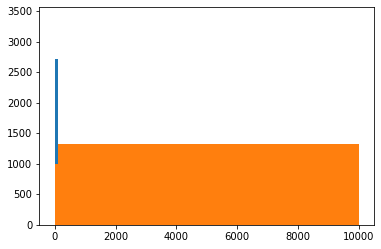

In [14]:
bins = list(range(10)) + [10, max_value_train+1, max_value_test]

dataset = split2dataset['train']
#res_counts = Counter([x['res'] for x in dataset])
#print(sorted(list(res_counts.items())))

n, _, _ = plt.hist([x['res'] for x in dataset], bins=bins)
n = n/n.sum()
print(list(zip(bins, np.round(n*100, 2))))
#plt.show()
#print(random.sample(dataset, k=3))

dataset = split2dataset['val']
res_counts = Counter([x['res'] for x in dataset])
#print(sorted(list(res_counts.items())))
n, _, _ = plt.hist([x['res'] for x in dataset], bins=bins)
n = n/n.sum()
print(list(zip(bins, np.round(n*100, 2))))
#print(random.sample(dataset, k=3))

train 11170 100
[('(', 22268), (')', 22268), ('*', 12874), ('+', 14906), ('-', 14436), ('/', 12954), ('0', 5636), ('1', 7048), ('2', 6973), ('3', 6922), ('4', 6721), ('5', 6720), ('6', 6567), ('7', 6654), ('8', 6601), ('9', 6498)]
[('(', 2989), (')', 2983), ('*', 450), ('+', 4082), ('-', 4516), ('/', 117), ('0', 1357), ('1', 4745), ('2', 4657), ('3', 1851), ('4', 1230), ('5', 756), ('6', 609), ('7', 564), ('8', 548), ('9', 556)]
2/6-(4-(6+1)+6)-(0+(2*6+6)) [1, 3, 1, 15, 12, 6, 12, 9, 9, 6, 9, 9, 3, 12, 12, -1, 18, 18, 15, 23, 21, 23, 21, 18, 23, 23, 18] [2, 1, 6, 0, None, 4, 0, None, 6, 7, 1, None, 6, 6, None, 0, None, 0, 18, None, 2, 12, 6, 18, 6, None, None] 0


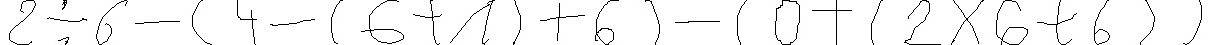

(3-3)*(2-1)-(8+0)-(8+2-4+1) [2, 2, 5, 2, 2, 11, 8, 8, 5, 8, 8, 17, 14, 14, 11, 14, 14, -1, 24, 20, 22, 20, 24, 22, 17, 24, 24] [None, 3, 0, 3, None, 0, None, 2, 1, 1, None, 0, None, 8, 8, 0, None, 0, None, 8, 10, 2, 6, 4, 7, 1, None] 0


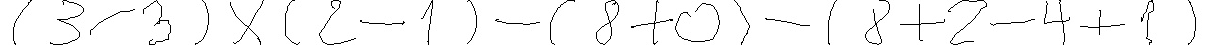

6+(8/1*4-5/9+(8*5-8)) [1, -1, 12, 4, 6, 4, 8, 6, 12, 10, 8, 10, 1, 17, 15, 17, 15, 12, 17, 17, 12] [6, 69, None, 8, 8, 1, 32, 4, 31, 5, 1, 9, 63, None, 8, 40, 5, 32, 8, None, None] 69


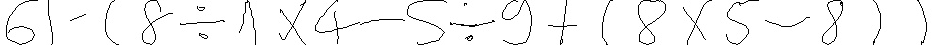

9+0 [1, -1, 1] [9, 9, 0] 9


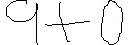

(5+(6-8)+9)/(6-9/(9*5))+(3+6-3) [8, 2, 8, 5, 5, 2, 5, 5, 11, 8, 8, 23, 14, 14, 11, 16, 14, 19, 19, 16, 19, 19, 14, -1, 28, 26, 28, 26, 23, 28, 28] [None, 5, 5, None, 6, 0, 8, None, 14, 9, None, 3, None, 6, 5, 9, 1, None, 9, 45, 5, None, None, 9, None, 3, 9, 6, 6, 3, None] 9


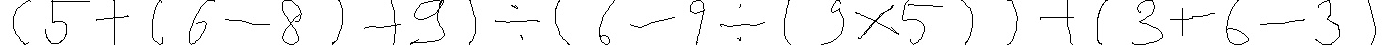

val 4900 9900
[('(', 21081), (')', 21081), ('*', 13491), ('+', 13199), ('-', 10734), ('/', 9876), ('0', 4016), ('1', 5142), ('2', 5321), ('3', 5241), ('4', 5279), ('5', 5383), ('6', 5427), ('7', 5462), ('8', 5453), ('9', 5476)]
[('(', 199), (')', 198), ('*', 30), ('+', 272), ('-', 301), ('/', 7), ('0', 90), ('1', 316), ('2', 310), ('3', 123), ('4', 82), ('5', 50), ('6', 40), ('7', 37), ('8', 36), ('9', 37)]
4*(3*2*4)*(4/(3/(9-(5-2)+(9+1/2)))) [1, 9, 6, 4, 6, 4, 1, 6, 6, -1, 12, 12, 9, 15, 15, 12, 24, 18, 24, 21, 21, 18, 21, 21, 15, 27, 27, 24, 29, 27, 29, 27, 24, 15, 12] [4, 96, None, 3, 6, 2, 24, 4, None, 384, None, 4, 4, None, 3, 1, None, 9, 6, None, 5, 3, 2, None, 16, None, 9, 10, 1, 1, 2, None, None, None, None] 384


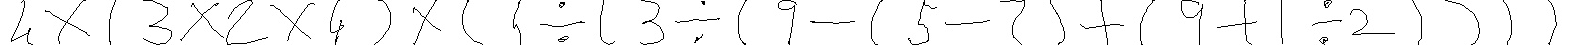

((0+3)/2+8)*(4*1+5) [8, 3, 3, 6, 3, 3, 8, 6, 11, 8, 8, -1, 16, 14, 16, 14, 11, 16, 16] [None, None, 0, 3, 3, None, 2, 2, 10, 8, None, 90, None, 4, 4, 1, 9, 5, None] 90


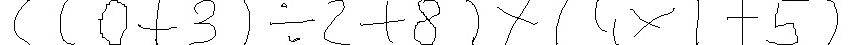

(1*2/7-2)*(9/1)/(8+9+(3+9)) [6, 2, 4, 2, 6, 4, 9, 6, 6, 15, 12, 12, 9, 12, 12, -1, 20, 18, 20, 18, 15, 23, 23, 20, 23, 23, 20] [None, 1, 2, 2, 1, 7, 0, 2, None, 0, None, 9, 9, 1, None, 0, None, 8, 17, 9, 29, None, 3, 12, 9, None, None] 0


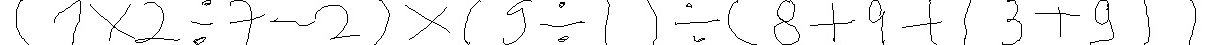

6*(3/3-(3+2-0/(3/5)))*(6+6) [1, 21, 6, 4, 6, 4, 1, 11, 9, 11, 9, 6, 13, 11, 16, 16, 13, 16, 16, 11, 6, -1, 24, 24, 21, 24, 24] [6, 0, None, 3, 1, 3, 0, None, 3, 5, 2, 5, 0, 0, None, 3, 1, 5, None, None, None, 0, None, 6, 12, 6, None] 0


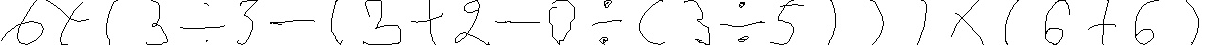

6*(5*(8*4+3))+(8*(6-3)+1+(4*2-(2/(2/(1*4+2*5))*(1-4+4)-5))) [1, 13, 4, 4, 1, 9, 7, 9, 7, 4, 9, 9, 4, -1, 24, 16, 22, 19, 19, 16, 19, 19, 24, 22, 13, 29, 27, 29, 27, 24, 54, 32, 46, 35, 35, 32, 40, 38, 40, 38, 35, 42, 40, 42, 40, 35, 54, 51, 49, 51, 49, 46, 51, 51, 29, 54, 54, 29, 24] [6, 1050, None, 5, 175, None, 8, 32, 4, 35, 3, None, None, 1080, None, 8, 24, None, 6, 3, 3, None, 25, 1, 30, None, 4, 8, 2, 5, None, 2, 2, None, 2, 1, None, 1, 4, 4, 14, 2, 10, 5, None, None, 8, None, 1, 0, 4, 4, 4, None, 3, 5, None, None, None] 1080


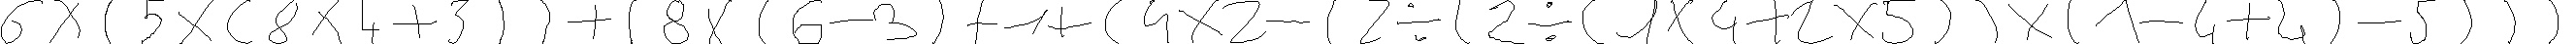

test 48910 9990
[('(', 210691), (')', 210691), ('*', 132837), ('+', 131914), ('-', 108556), ('/', 99343), ('0', 39465), ('1', 51797), ('2', 52546), ('3', 52953), ('4', 53234), ('5', 53430), ('6', 53860), ('7', 54695), ('8', 54671), ('9', 54909)]
[('(', 798), (')', 797), ('*', 120), ('+', 1089), ('-', 1205), ('/', 33), ('0', 363), ('1', 1266), ('2', 1243), ('3', 495), ('4', 329), ('5', 202), ('6', 163), ('7', 152), ('8', 147), ('9', 149)]
7*(3*3+1*(3-7/4))/6*(((8+8)*(6+9)-(4+(8*(2-9)+9)))/(3*9)) [1, 17, 6, 4, 6, 4, 1, 8, 6, 11, 11, 8, 13, 11, 13, 11, 6, 19, 17, -1, 50, 33, 24, 24, 27, 24, 24, 33, 30, 30, 27, 30, 30, 50, 36, 36, 33, 45, 39, 45, 42, 42, 39, 42, 42, 36, 45, 45, 36, 33, 19, 53, 53, 50, 53, 53, 50] [7, 70, None, 3, 9, 3, 10, 1, 1, None, 3, 1, 7, 2, 4, None, None, 12, 6, 108, None, None, None, 8, 16, 8, None, 240, None, 6, 15, 9, None, 227, None, 4, 13, None, 8, 0, None, 2, 0, 9, None, 9, 9, None, None, None, 9, None, 3, 27, 9, None, None] 108


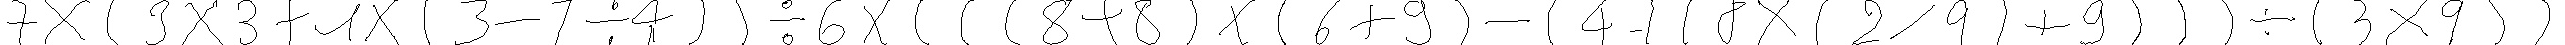

(1/8-1)/((2/8+7)*1*(4*7/8)) [4, 2, 4, 2, 7, 4, 4, -1, 18, 13, 11, 13, 11, 16, 13, 13, 18, 16, 7, 23, 21, 23, 21, 18, 23, 23, 18] [None, 1, 1, 8, 0, 1, None, 0, None, None, 2, 1, 8, 8, 7, None, 8, 1, 32, None, 4, 28, 7, 4, 8, None, None] 0


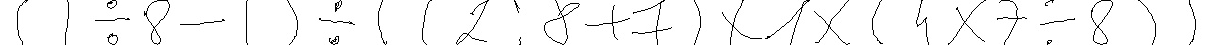

(7*(5*5/5)+9/8)*(3+1/(3*1)) [10, 2, 10, 7, 5, 7, 5, 2, 7, 7, 15, 12, 10, 12, 10, -1, 18, 18, 15, 20, 18, 23, 23, 20, 23, 23, 18] [None, 7, 35, None, 5, 25, 5, 5, 5, None, 37, 9, 2, 8, None, 148, None, 3, 4, 1, 1, None, 3, 3, 1, None, None] 148


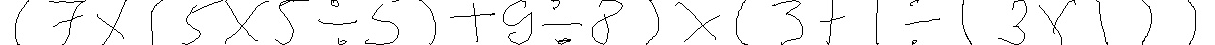

7*(9+(4+2)) [1, -1, 4, 4, 1, 7, 7, 4, 7, 7, 4] [7, 105, None, 9, 15, None, 4, 6, 2, None, None] 105


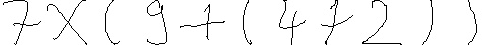

8+1 [1, -1, 1] [8, 9, 1] 9


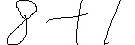

In [15]:
# Visualize data
import numpy as np
for split in splits:
    dataset = split2dataset[split]
    print(split, len(dataset), np.max([x['res'] for x in dataset]))
    all_symbols = [(x, y) for sample in dataset for x, y in zip(sample['img_paths'], sample['expr'])]
    print(sorted(Counter([x[1] for x in all_symbols]).items()))
    print(sorted(Counter([x[1] for x in set(all_symbols)]).items()))
    for _ in range(5):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']), sample['head'], sample['res_all'], sample['res'])
        display(img)

In [16]:
counts = sorted(Counter([x['eval'] for x in split2dataset['test']]).items())
total_count = sum([c for _, c in counts])
counts = [(k, round(v/total_count*100, 2)) for k, v in counts]
print(counts)
print(list({x['expr'] for x in split2dataset['test'] if x['eval'] == 3})[:10])
train_exprs = {x['expr'] for x in split2dataset['train']}
max_len_train = max([len(x) for x in train_exprs])
print(max_len_train)

[(1, 22.84), (2, 23.0), (3, 22.36), (4, 15.84), (5, 15.95)]
['9*5*(9/4)+1', '4/(1-6*(5/4*5*2)+4+6)/3/(5-3)', '(6+3)*(9*6-3)-(0*(9+3)-9)', '(8*3-8)*(4/7*5)*((6+2)/1)/4', '(9-4)/(5+7)*(((8-0)*8+7)*8)', '7-8+(9*4+8*(8*(8+2))*5)', '8*(2*(4*3/6)*(4+6))', '9*2*6', '6*((8+9)*(2*(6-5)))', '(3+(5+2))*(7*(4+5-4))']
37


(45, 45)


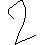

3+4*2 = 11


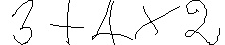

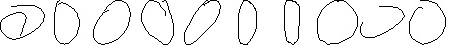

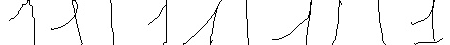

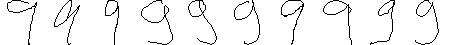

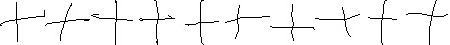

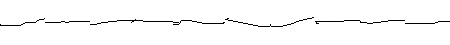

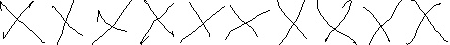

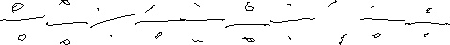

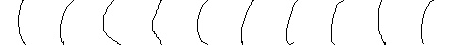

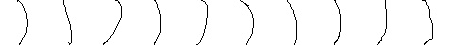

In [17]:
img = Image.open(symbol_images_dir + '2/2_849.jpg')
print(img.size)
display(img)

expr = '3+4*2'
img_paths = generate_img_paths(expr, sym_set=split2sym['train'])
img = render_img(img_paths)
print(expr,'=', eval(expr))
display(img)

for sym in '019+-*/()':
    expr = sym*10
    img_paths = generate_img_paths(expr, sym_set=split2sym['train'])
    img = render_img(img_paths)
    display(img)


In [18]:
def compute_depth(expr):
    depth = 0
    max_depth = 0
    for x in expr:
        if x == lps:
            c = 1
        elif x == rps:
            c = -1
        else:
            c = 0
        depth += c
        if depth > max_depth:
            max_depth = depth
    return max_depth

print(compute_depth('1*2*(1+2*((3+4)+(3-1))'))
ps_depths = [compute_depth(x['expr']) for x in split2dataset['train']]
print(Counter(ps_depths))

ps_depths = [compute_depth(x['expr']) for x in split2dataset['val']]
print(Counter(ps_depths))

3
Counter({2: 3320, 1: 3209, 0: 2978, 3: 1376, 4: 257, 5: 26, 6: 4})
Counter({2: 1451, 3: 1255, 1: 963, 4: 631, 0: 421, 5: 146, 6: 26, 7: 7})


4*(3+9)-7-(0-5) [1, 7, 4, 4, 1, 4, 4, 9, 7, -1, 12, 12, 9, 12, 12] [4, 48, None, 3, 12, 9, None, 41, 7, 41, None, 0, 0, 5, None] 41


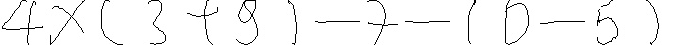

5*5+(9-0-2) [1, 3, 1, -1, 8, 6, 8, 6, 3, 8, 8] [5, 25, 5, 32, None, 9, 9, 0, 7, 2, None] 32


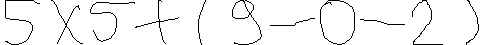

5-3*3/(9-8*(6/9))*(8-8) [1, -1, 3, 5, 3, 17, 8, 8, 5, 10, 8, 13, 13, 10, 13, 13, 8, 1, 20, 20, 17, 20, 20] [5, 5, 3, 9, 3, 9, None, 9, 1, 8, 8, None, 6, 1, 9, None, None, 0, None, 8, 0, 8, None] 5


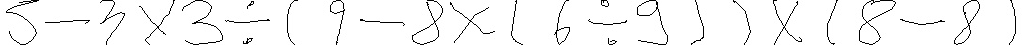

2*5/9 [1, 3, 1, -1, 3] [2, 10, 5, 2, 9] 2


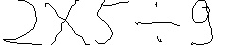

2/1/3/8 [1, 3, 1, 5, 3, -1, 5] [2, 2, 1, 1, 3, 1, 8] 1


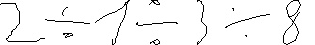

6+(6+5-5) [1, -1, 6, 4, 6, 4, 1, 6, 6] [6, 12, None, 6, 11, 5, 6, 5, None] 12


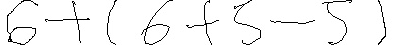

4/(1+0) [1, -1, 4, 4, 1, 4, 4] [4, 4, None, 1, 1, 0, None] 4


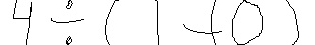

(4+2+2)*(2+9-(4+(0+0)/3)) [4, 2, 4, 2, 7, 4, 4, -1, 12, 10, 12, 10, 7, 15, 15, 12, 18, 18, 21, 18, 18, 15, 21, 15, 12] [None, 4, 6, 2, 8, 2, None, 56, None, 2, 11, 9, 7, None, 4, 4, None, 0, 0, 0, None, 0, 3, None, None] 56


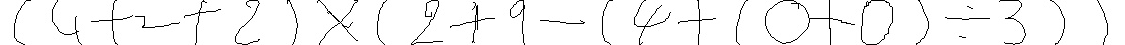

8-(6-(7+4)-7) [1, -1, 10, 4, 10, 7, 7, 4, 7, 7, 1, 10, 10] [8, 8, None, 6, 0, None, 7, 11, 4, None, 0, 7, None] 8


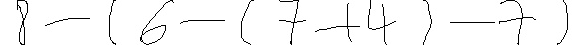

(1-7)/((7+6)/5*(4+4)) [2, 2, 5, 2, 2, -1, 14, 9, 9, 12, 9, 9, 14, 12, 5, 17, 17, 14, 17, 17, 14] [None, 1, 0, 7, None, 0, None, None, 7, 13, 6, None, 3, 5, 24, None, 4, 8, 4, None, None] 0


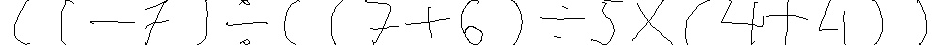

In [36]:
dataset = [x for x in split2dataset['train']]
for _ in range(10):
    sample = random.choice(dataset)
    img_paths = sample['img_paths']
    img = render_img(img_paths)
    print("".join(sample['expr']), sample['head'], sample['res_all'], sample['res'])
    display(img)

1 ============================================================
1 [-1] [1] 1


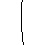

1*0 [1, -1, 1] [1, 0, 0] 0


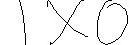

1/4 [1, -1, 1] [1, 1, 4] 1


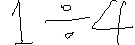

9 [-1] [9] 9


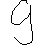

1*(2/5)*(8-8-6) [1, 7, 4, 4, 1, 4, 4, -1, 12, 10, 12, 10, 7, 12, 12] [1, 1, None, 2, 1, 5, None, 0, None, 8, 0, 8, 0, 6, None] 0


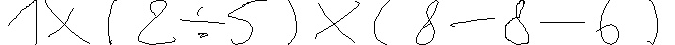

2/3-((4-9)/(2*3)+(4+5)) [1, 3, 1, -1, 16, 7, 7, 10, 7, 7, 16, 13, 13, 10, 13, 13, 3, 19, 19, 16, 19, 19, 16] [2, 1, 3, 0, None, None, 4, 0, 9, None, 0, None, 2, 6, 3, None, 9, None, 4, 9, 5, None, None] 0


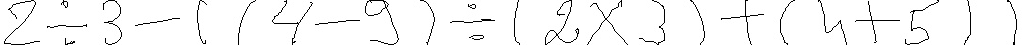

3-5/5/1-3-8*2 [1, 7, 3, 5, 3, 1, 5, 9, 7, -1, 11, 9, 11] [3, 2, 5, 1, 5, 1, 1, 0, 3, 0, 8, 16, 2] 0


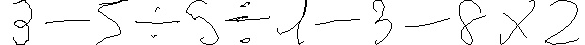

8 [-1] [8] 8


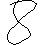

6-4+(0-(6+0/(4/(6/1)*1)))+(9+4) [1, 3, 1, 25, 6, 6, 3, 9, 9, 6, 11, 9, 20, 14, 20, 17, 17, 14, 17, 17, 11, 20, 20, 9, 6, -1, 28, 28, 25, 28, 28] [6, 2, 4, 2, None, 0, 0, None, 6, 6, 0, 0, None, 4, 1, None, 6, 6, 1, None, 1, 1, None, None, None, 15, None, 9, 13, 4, None] 15


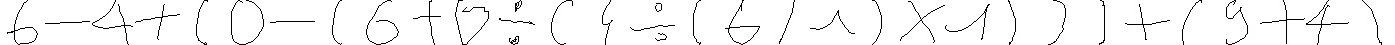

(4/8-(9-4/6-3/(9*(0/2)+5)))/6 [4, 2, 4, 2, 27, 11, 7, 11, 9, 7, 9, 4, 13, 11, 22, 16, 22, 19, 19, 16, 19, 19, 13, 22, 22, 11, 4, -1, 27] [None, 4, 1, 8, 0, None, 9, 8, 4, 1, 6, 7, 3, 1, None, 9, 0, None, 0, 0, 2, None, 5, 5, None, None, None, 0, 6] 0


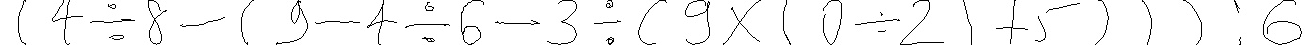

2 ============================================================
1+3/4 [1, -1, 3, 1, 3] [1, 2, 3, 1, 4] 2


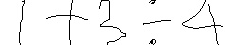

3*(7*2)+(8+4)+4*3 [1, 7, 4, 4, 1, 4, 4, 13, 10, 10, 7, 10, 10, -1, 15, 13, 15] [3, 42, None, 7, 14, 2, None, 54, None, 8, 12, 4, None, 66, 4, 12, 3] 66


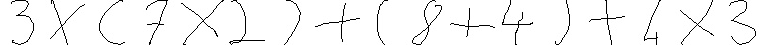

4+(0-(7+7+6))*4-0 [1, 15, 4, 4, 13, 9, 7, 9, 7, 4, 9, 9, 4, 1, 13, -1, 15] [4, 4, None, 0, 0, None, 7, 14, 7, 20, 6, None, None, 0, 4, 4, 0] 4


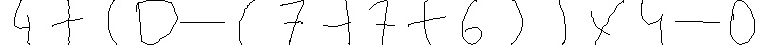

(2+6)/(5+3+1/(6+1))*(6*(2/1/(6+8)-2)) [2, 2, 5, 2, 2, 19, 10, 8, 10, 8, 5, 12, 10, 15, 15, 12, 15, 15, 10, -1, 22, 22, 19, 33, 25, 27, 25, 33, 30, 30, 27, 30, 30, 22, 33, 33, 22] [None, 2, 8, 6, None, 1, None, 5, 8, 3, 9, 1, 1, None, 6, 7, 1, None, None, 0, None, 6, 0, None, 2, 2, 1, 1, None, 6, 14, 8, None, 0, 2, None, None] 0


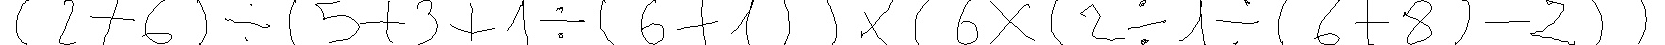

1*(1-3)/(9/(9*9))+(8+7) [1, 7, 4, 4, 1, 4, 4, 17, 10, 10, 7, 13, 13, 10, 13, 13, 10, -1, 20, 20, 17, 20, 20] [1, 0, None, 1, 0, 3, None, 0, None, 9, 1, None, 9, 81, 9, None, None, 15, None, 8, 15, 7, None] 15


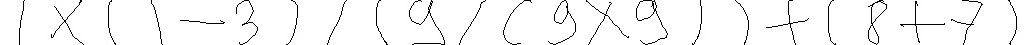

8/9*3/(4/7+3)*(1*(7*6)+(3-7)-(9+4)*3) [1, 3, 1, 5, 3, 13, 10, 8, 10, 8, 5, 10, 10, -1, 28, 16, 22, 19, 19, 16, 19, 19, 28, 25, 25, 22, 25, 25, 13, 31, 31, 34, 31, 31, 28, 34, 28] [8, 1, 9, 3, 3, 1, None, 4, 1, 7, 4, 3, None, 3, None, 1, 42, None, 7, 42, 6, None, 42, None, 3, 0, 7, None, 3, None, 9, 13, 4, None, 39, 3, None] 3


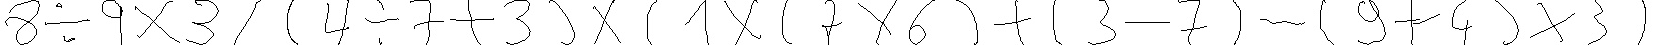

3*6*(8/3)+(5-(2-7))*9 [1, 3, 1, 9, 6, 6, 3, 6, 6, -1, 12, 12, 19, 15, 15, 12, 15, 15, 12, 9, 19] [3, 18, 6, 54, None, 8, 3, 3, None, 99, None, 5, 5, None, 2, 0, 7, None, None, 45, 9] 99


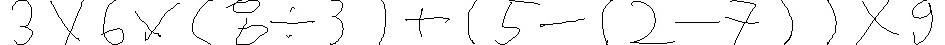

3+7-9 [1, 3, 1, -1, 3] [3, 10, 7, 1, 9] 1


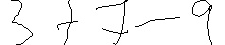

8/6+(0+(0-(6-2*0))) [1, 3, 1, -1, 6, 6, 3, 9, 9, 6, 12, 12, 9, 14, 12, 14, 12, 9, 6] [8, 2, 6, 2, None, 0, 0, None, 0, 0, None, 6, 6, 2, 0, 0, None, None, None] 2


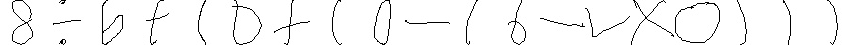

(6*4+9*6-3)*(4/9+0*6) [8, 2, 4, 2, 8, 6, 4, 6, 11, 8, 8, -1, 16, 14, 16, 14, 11, 18, 16, 18, 16] [None, 6, 24, 4, 78, 9, 54, 6, 75, 3, None, 75, None, 4, 1, 9, 1, 0, 0, 6, None] 75


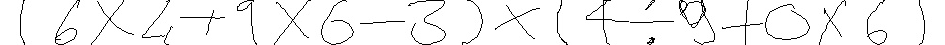

3 ============================================================
3*(8*(8*1)+0/9) [1, -1, 10, 4, 10, 7, 7, 4, 7, 7, 1, 12, 10, 12, 10] [3, 192, None, 8, 64, None, 8, 8, 1, None, 64, 0, 0, 9, None] 192


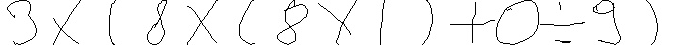

5*(3/1*9)+(2-5)*(7*(6+5)) [1, 9, 6, 4, 6, 4, 1, 6, 6, -1, 12, 12, 15, 12, 12, 9, 18, 18, 15, 21, 21, 18, 21, 21, 18] [5, 135, None, 3, 3, 1, 27, 9, None, 135, None, 2, 0, 5, None, 0, None, 7, 77, None, 6, 11, 5, None, None] 135


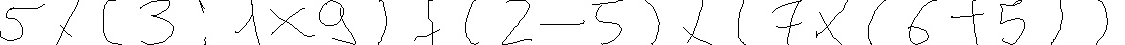

(6+1)*(5*(9-1+7)*(4+7+6/1-2*6)) [2, 2, 5, 2, 2, -1, 16, 8, 16, 13, 11, 13, 11, 8, 13, 13, 5, 25, 19, 21, 19, 25, 23, 21, 23, 16, 27, 25, 27, 25, 16] [None, 6, 7, 1, None, 2625, None, 5, 75, None, 9, 8, 1, 15, 7, None, 375, None, 4, 11, 7, 17, 6, 6, 1, 5, 2, 12, 6, None, None] 2625


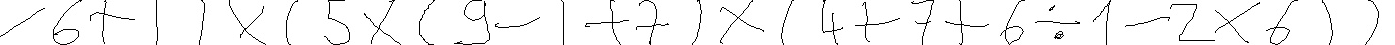

2*(3*(3/6+6*(3*4*6/(1*6)))+0/3) [1, -1, 26, 4, 26, 9, 7, 9, 7, 4, 11, 9, 18, 14, 16, 14, 18, 16, 11, 21, 21, 18, 21, 21, 18, 9, 1, 28, 26, 28, 26] [2, 438, None, 3, 219, None, 3, 1, 6, 73, 6, 72, None, 3, 12, 4, 72, 6, 12, None, 1, 6, 6, None, None, None, 219, 0, 0, 3, None] 438


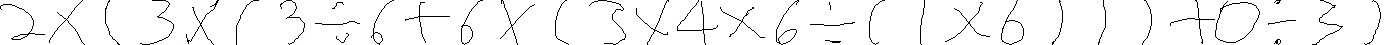

7*8*5 [1, 3, 1, -1, 3] [7, 56, 8, 280, 5] 280


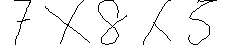

(7/(1+0)*(9+6)-(2+0*3))/(8-7)+5 [14, 2, 8, 5, 5, 2, 5, 5, 14, 11, 11, 8, 11, 11, 23, 17, 17, 14, 19, 17, 19, 17, 14, 29, 26, 26, 23, 26, 26, -1, 29] [None, 7, 7, None, 1, 1, 0, None, 105, None, 9, 15, 6, None, 103, None, 2, 2, 0, 0, 3, None, None, 103, None, 8, 1, 7, None, 108, 5] 108


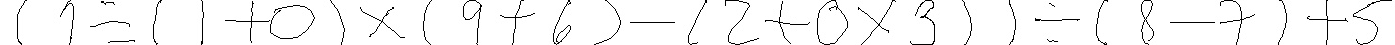

4-9+(9+(1+2))*(3+(0-0+9)-7/4/7) [1, 3, 1, -1, 6, 6, 13, 9, 9, 6, 9, 9, 6, 3, 24, 16, 24, 21, 19, 21, 19, 16, 21, 21, 13, 26, 28, 26, 24, 28, 24] [4, 0, 9, 132, None, 9, 12, None, 1, 3, 2, None, None, 132, None, 3, 12, None, 0, 0, 0, 9, 9, None, 11, 7, 2, 4, 1, 7, None] 132


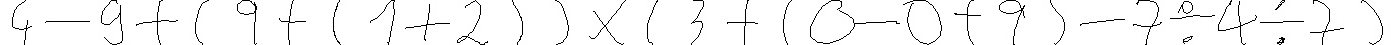

4/(6*3*(8+5/1)) [1, -1, 6, 4, 6, 4, 1, 9, 9, 6, 11, 9, 11, 9, 6] [4, 1, None, 6, 18, 3, 234, None, 8, 13, 5, 5, 1, None, None] 1


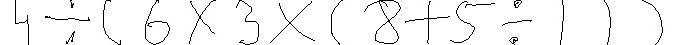

8*(8+6) [1, -1, 4, 4, 1, 4, 4] [8, 112, None, 8, 14, 6, None] 112


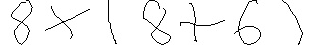

1/(2*6)*(3*(8*8)) [1, 7, 4, 4, 1, 4, 4, -1, 10, 10, 7, 13, 13, 10, 13, 13, 10] [1, 1, None, 2, 12, 6, None, 192, None, 3, 192, None, 8, 64, 8, None, None] 192


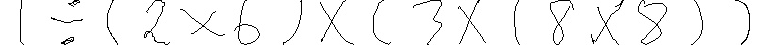

4 ============================================================
(6*5-0)/((4+9+5)/9)+(3-((2-(2+(9*7-8/9)))/4-9)) [4, 2, 4, 2, 7, 4, 4, 19, 16, 13, 11, 13, 11, 16, 13, 13, 7, 16, 16, -1, 22, 22, 19, 43, 26, 26, 41, 29, 29, 26, 34, 32, 34, 32, 29, 36, 34, 36, 34, 29, 26, 43, 41, 22, 43, 43, 22] [None, 6, 30, 5, 30, 0, None, 15, None, None, 4, 13, 9, 18, 5, None, 2, 9, None, 18, None, 3, 3, None, None, 2, 0, None, 2, 64, None, 9, 63, 7, 62, 8, 1, 9, None, None, None, 0, 4, 0, 9, None, None] 18


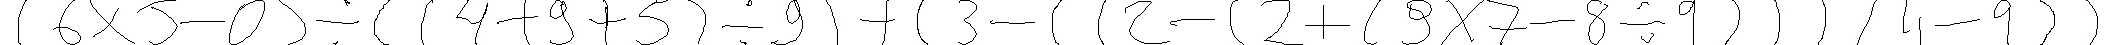

6-3/(9*(9/(4-(4-7))))+(1+1/(5-2))/(7*2+6/8) [1, 21, 3, 1, 6, 6, 3, 9, 9, 6, 12, 12, 9, 15, 15, 12, 15, 15, 12, 9, 6, -1, 24, 24, 33, 26, 24, 29, 29, 26, 29, 29, 24, 21, 38, 36, 38, 36, 33, 40, 38, 40, 38] [6, 5, 3, 1, None, 9, 27, None, 9, 3, None, 4, 4, None, 4, 0, 7, None, None, None, None, 6, None, 1, 2, 1, 1, None, 5, 3, 2, None, None, 1, None, 7, 14, 2, 15, 6, 1, 8, None] 6


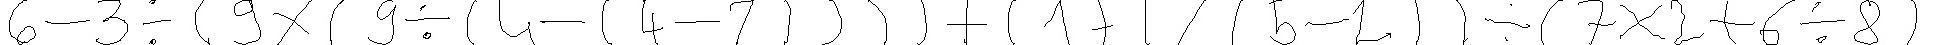

(7+3)/(6-6*(0*(6/1)))-(3*1-6-4/(4-3))*(9*3) [2, 2, 5, 2, 2, 21, 8, 8, 5, 10, 8, 13, 13, 10, 16, 16, 13, 16, 16, 13, 8, -1, 28, 24, 26, 24, 28, 26, 37, 30, 28, 33, 33, 30, 33, 33, 28, 21, 40, 40, 37, 40, 40] [None, 7, 10, 3, None, 2, None, 6, 6, 6, 0, None, 0, 0, None, 6, 6, 1, None, None, None, 2, None, 3, 3, 1, 0, 6, 0, 4, 4, None, 4, 1, 3, None, None, 0, None, 9, 27, 3, None] 2


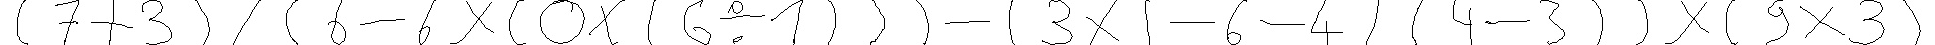

(5-((2-4)/2+5)+2*(8/8))*(0+1+1-9/3+7-8*1-2)+0 [14, 2, 14, 11, 6, 6, 9, 6, 6, 11, 9, 2, 11, 11, 23, 16, 14, 19, 19, 16, 19, 19, 14, 43, 40, 26, 28, 26, 30, 28, 34, 32, 30, 32, 36, 34, 40, 38, 36, 38, 23, 40, 40, -1, 43] [None, 5, 0, None, None, 2, 0, 4, None, 0, 2, 5, 5, None, 2, 2, 2, None, 8, 1, 8, None, None, 0, None, 0, 1, 1, 2, 1, 0, 9, 3, 3, 7, 7, 0, 8, 8, 1, 0, 2, None, 0, 0] 0


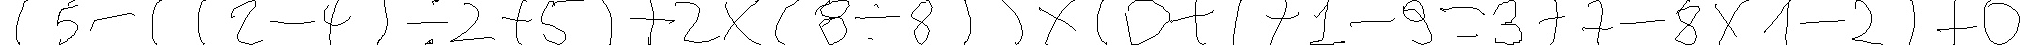

3-(5-4)+(4/7-7/(1/(7*6)/6*(6/2)))*(4+(7-9+7)*(5/(7*4-2-2))) [1, 7, 4, 4, 1, 4, 4, -1, 12, 10, 12, 10, 33, 14, 12, 25, 17, 23, 20, 20, 17, 20, 20, 25, 23, 14, 28, 28, 25, 28, 28, 25, 12, 7, 36, 36, 33, 41, 39, 41, 39, 44, 41, 41, 36, 47, 47, 44, 54, 50, 52, 50, 54, 52, 47, 54, 54, 47, 36] [3, 2, None, 5, 1, 4, None, 2, None, 4, 1, 7, 0, 7, 3, None, 1, 1, None, 7, 42, 6, None, 1, 6, 3, None, 6, 3, 2, None, None, None, 0, None, 4, 11, None, 7, 0, 9, 7, 7, None, 7, None, 5, 1, None, 7, 28, 4, 26, 2, 24, 2, None, None, None] 2


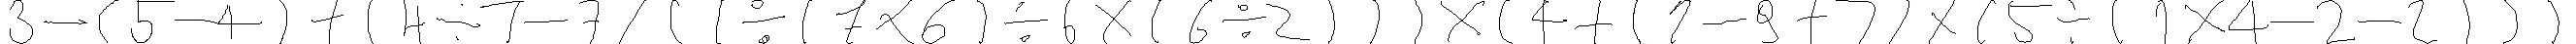

(0/(6/8)+7/7)/(0/9+8+(3/(5/6/(9/8))+(3-7)-(8+2*3/7))-7) [8, 2, 8, 5, 5, 2, 5, 5, 13, 10, 8, 10, 8, -1, 52, 16, 18, 16, 20, 18, 52, 41, 23, 35, 28, 26, 28, 26, 23, 31, 31, 28, 31, 31, 28, 41, 38, 38, 35, 38, 38, 20, 44, 44, 41, 46, 48, 46, 44, 48, 44, 41, 13, 52, 52] [None, 0, 0, None, 6, 1, 8, None, 1, 7, 1, 7, None, 1, None, 0, 0, 9, 8, 8, 8, None, 3, 3, None, 5, 1, 6, 1, None, 9, 2, 8, None, None, 3, None, 3, 0, 7, None, 0, None, 8, 9, 2, 6, 3, 1, 7, None, None, 1, 7, None] 1


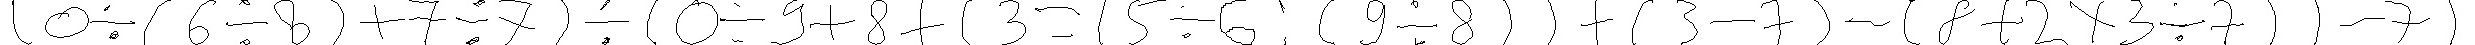

(4+2*8-(1-4+2)/8)*((2-0+2/9+(0-2*0*(7*9)))*4/(6+3)) [6, 2, 6, 4, 2, 4, 17, 11, 9, 11, 9, 14, 11, 11, 6, 14, 6, -1, 44, 27, 21, 23, 21, 27, 25, 23, 25, 42, 30, 30, 27, 32, 34, 32, 30, 37, 37, 34, 37, 37, 30, 27, 44, 42, 17, 47, 47, 44, 47, 47, 44] [None, 4, 20, 2, 16, 8, 19, None, 1, 0, 4, 2, 2, None, 1, 8, None, 38, None, None, 2, 2, 0, 3, 2, 1, 9, 3, None, 0, 0, 2, 0, 0, 0, None, 7, 63, 9, None, None, None, 12, 4, 2, None, 6, 9, 3, None, None] 38


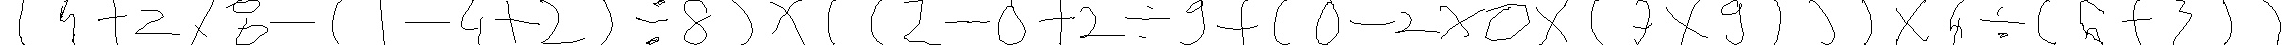

1*(1*9)/(9/5/(1*4)-7*8+(9-(7-4)))-(8*2+3) [1, 7, 4, 4, 1, 4, 4, 33, 22, 10, 12, 10, 18, 15, 15, 12, 15, 15, 22, 20, 18, 20, 7, 25, 25, 22, 28, 28, 25, 28, 28, 25, 22, -1, 38, 36, 38, 36, 33, 38, 38] [1, 9, None, 1, 9, 9, None, 2, None, 9, 2, 5, 1, None, 1, 4, 4, None, 0, 7, 56, 8, 6, None, 9, 6, None, 7, 3, 4, None, None, None, 0, None, 8, 16, 2, 19, 3, None] 0


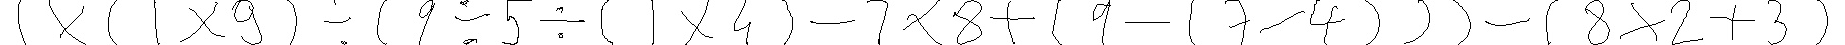

4/9/((9+8)/(4+3))/(2+4/6)-((8-6)*(9/9)-5) [1, 3, 1, 17, 10, 7, 7, 10, 7, 7, 3, 13, 13, 10, 13, 13, 10, 25, 20, 20, 17, 22, 20, 22, 20, -1, 38, 29, 29, 32, 29, 29, 38, 35, 35, 32, 35, 35, 25, 38, 38] [4, 1, 9, 1, None, None, 9, 17, 8, None, 3, None, 4, 7, 3, None, None, 1, None, 2, 3, 4, 1, 6, None, 1, None, None, 8, 2, 6, None, 2, None, 9, 1, 9, None, 0, 5, None] 1


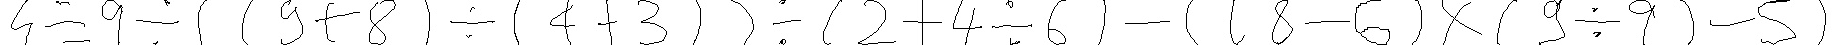

(7/5+1-(9-0)+((7-0*5)*(6/4+5)-(6-(0+5)))-(3-4/3*8))/2 [40, 2, 4, 2, 6, 4, 12, 9, 9, 6, 9, 9, 40, 29, 16, 16, 21, 18, 16, 18, 16, 29, 26, 24, 26, 24, 21, 26, 26, 12, 32, 32, 29, 35, 35, 32, 35, 35, 32, 29, 51, 43, 43, 40, 45, 47, 45, 43, 47, 43, 40, -1, 51] [None, 7, 2, 5, 3, 1, 0, None, 9, 9, 0, None, 48, None, None, 7, 7, 0, 0, 5, None, 49, None, 6, 2, 4, 7, 5, None, 48, None, 6, 1, None, 0, 5, 5, None, None, None, 48, None, 3, 0, 4, 2, 3, 16, 8, None, None, 24, 2] 24


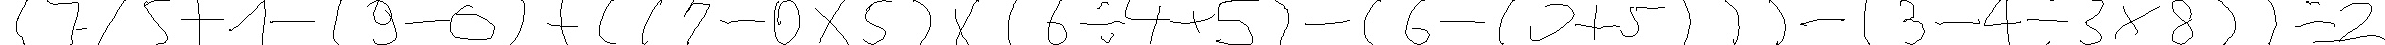

5 ============================================================
(3+(8+(4-7*(7+8))*(8/4-(4-(6+5)+6))))/(7+5*1*0)/5 [2, 2, 37, 5, 5, 2, 8, 8, 17, 10, 8, 13, 13, 10, 13, 13, 8, 5, 22, 20, 22, 20, 17, 31, 25, 31, 28, 28, 25, 28, 28, 22, 31, 31, 22, 5, 2, 47, 40, 40, 37, 42, 44, 42, 40, 44, 40, -1, 47] [None, 3, 11, None, 8, 8, None, 4, 0, 7, 105, None, 7, 15, 8, None, None, 0, None, 8, 2, 4, 0, None, 4, 0, None, 6, 11, 5, None, 6, 6, None, None, None, None, 2, None, 7, 7, 5, 5, 1, 0, 0, None, 1, 5] 1


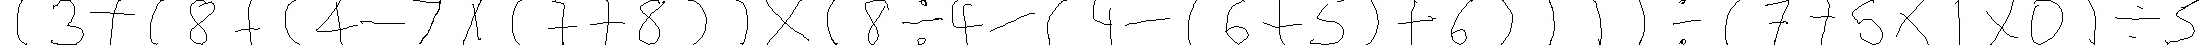

(6+7*1+2/4+(1+4-0/3)*8-(1+3*8))*((0+(2*9-0)/3)/(8/9)) [22, 2, 6, 4, 2, 4, 10, 8, 6, 8, 22, 15, 13, 15, 13, 20, 17, 15, 17, 15, 10, 20, 31, 25, 25, 22, 27, 25, 27, 25, 22, -1, 46, 35, 35, 46, 40, 38, 40, 38, 43, 40, 40, 35, 43, 35, 31, 49, 49, 46, 49, 49, 46] [None, 6, 13, 7, 7, 1, 14, 2, 1, 4, 54, None, 1, 5, 4, 5, 0, 0, 3, None, 40, 8, 29, None, 1, 25, 3, 24, 8, None, None, 174, None, None, 0, 6, None, 2, 18, 9, 18, 0, None, 6, 3, None, 6, None, 8, 1, 9, None, None] 174


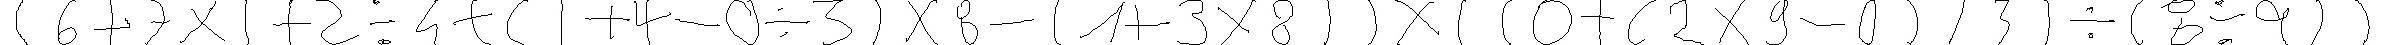

(9*9+(1+8*8)-(2*4*(3/1)-3*(2*2)))/(6-6+5*4) [12, 2, 4, 2, 12, 7, 7, 4, 9, 7, 9, 7, 33, 23, 15, 17, 15, 23, 20, 20, 17, 20, 20, 12, 25, 23, 28, 28, 25, 28, 28, 23, 12, -1, 38, 36, 38, 36, 33, 40, 38, 40, 38] [None, 9, 81, 9, 146, None, 1, 65, 8, 64, 8, None, 134, None, 2, 8, 4, 24, None, 3, 3, 1, None, 12, 3, 12, None, 2, 4, 2, None, None, None, 7, None, 6, 0, 6, 20, 5, 20, 4, None] 7


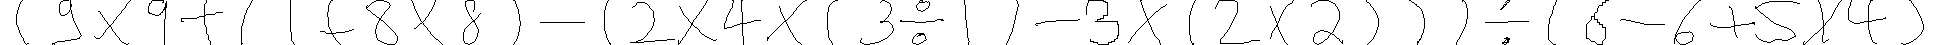

7*(8/(1*(7/7))+(1+2))*(0+9-5/(8+4/(9*6)))+(8-(9-8+3)) [1, 21, 14, 4, 14, 7, 7, 4, 10, 10, 7, 10, 10, 7, 1, 17, 17, 14, 17, 17, 14, 41, 26, 24, 26, 24, 21, 28, 26, 31, 31, 28, 33, 31, 36, 36, 33, 36, 36, 31, 26, -1, 44, 44, 41, 49, 47, 49, 47, 44, 49, 49, 44] [7, 77, None, 8, 8, None, 1, 1, None, 7, 1, 7, None, None, 11, None, 1, 3, 2, None, None, 616, None, 0, 9, 9, 8, 5, 1, None, 8, 9, 4, 1, None, 9, 54, 6, None, None, None, 620, None, 8, 4, None, 9, 1, 8, 4, 3, None, None] 620


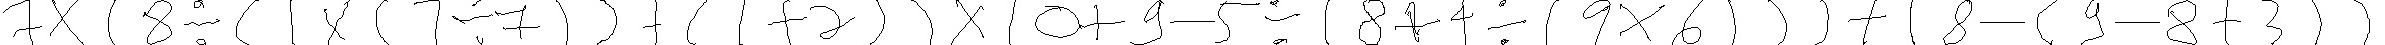

1/4+8*(1+(1*1+(0-(1+0)+7))*(8*(8+(3-1)))) [1, 3, 1, -1, 5, 3, 8, 8, 5, 13, 11, 13, 11, 26, 22, 16, 22, 19, 19, 16, 19, 19, 13, 22, 22, 13, 8, 29, 29, 26, 32, 32, 29, 35, 35, 32, 35, 35, 32, 29, 8] [1, 1, 4, 5129, 8, 5128, None, 1, 641, None, 1, 1, 1, 8, None, 0, 0, None, 1, 1, 0, None, 7, 7, None, None, 640, None, 8, 80, None, 8, 10, None, 3, 2, 1, None, None, None, None] 5129


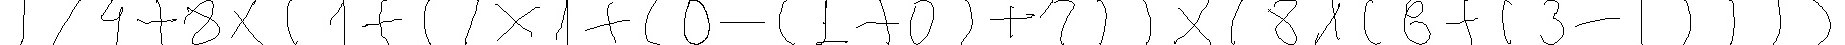

7*(3/5)/((6*7-9/1)/(1-(7+2)+(6+(1-5*(6-1+4)))*9*(6-4))) [1, 7, 4, 4, 1, 4, 4, -1, 18, 13, 11, 13, 11, 18, 15, 13, 15, 13, 7, 27, 21, 27, 24, 24, 21, 24, 24, 18, 30, 30, 45, 33, 33, 30, 35, 33, 40, 38, 40, 38, 35, 40, 40, 33, 30, 47, 45, 27, 50, 50, 47, 50, 50, 27, 18] [7, 7, None, 3, 1, 5, None, 7, None, None, 6, 42, 7, 33, 9, 9, 1, None, 1, None, 1, 0, None, 7, 9, 2, None, 108, None, 6, 6, None, 1, 0, 5, 45, None, 6, 5, 1, 9, 4, None, None, None, 54, 9, 108, None, 6, 2, 4, None, None, None] 7


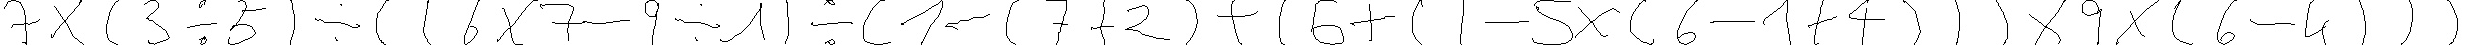

(7+1)*(3*(2*8))/1*(8/4-(0/4+(2-7)/5))+((9/9+9)/8+(4+0-(4+3))) [2, 2, 5, 2, 2, 15, 8, 8, 5, 11, 11, 8, 11, 11, 8, 17, 15, 37, 22, 20, 22, 20, 17, 27, 25, 27, 25, 22, 30, 30, 33, 30, 30, 27, 33, 27, 22, -1, 48, 43, 41, 43, 41, 46, 43, 43, 48, 46, 37, 53, 51, 53, 51, 48, 56, 56, 53, 56, 56, 53, 48] [None, 7, 8, 1, None, 384, None, 3, 48, None, 2, 16, 8, None, None, 384, 1, 768, None, 8, 2, 4, 2, None, 0, 0, 4, 0, None, 2, 0, 7, None, 0, 5, None, None, 770, None, None, 9, 1, 9, 10, 9, None, 2, 8, 2, None, 4, 4, 0, 0, None, 4, 7, 3, None, None, None] 770


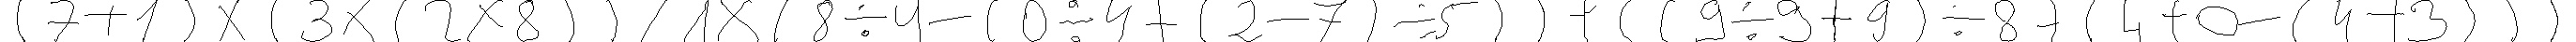

4*7+(1-8/(6/3-0)*4*(8*(7*2)))-3*5*(1-1) [1, 3, 1, 29, 6, 6, 3, 8, 16, 13, 11, 13, 11, 8, 13, 13, 18, 16, 6, 21, 21, 18, 24, 24, 21, 24, 24, 21, 6, -1, 31, 33, 31, 29, 36, 36, 33, 36, 36] [4, 28, 7, 28, None, 1, 0, 8, 4, None, 6, 2, 3, 2, 0, None, 16, 4, 1792, None, 8, 112, None, 7, 14, 2, None, None, None, 28, 3, 15, 5, 0, None, 1, 0, 1, None] 28


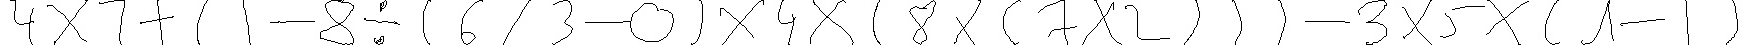

(4-1+(0+0))/(4*5*(1+(6+8+(5/9-5/(9/3))))) [4, 2, 4, 2, 11, 7, 7, 4, 7, 7, 4, -1, 16, 14, 16, 14, 11, 19, 19, 16, 24, 22, 24, 22, 19, 29, 27, 29, 27, 24, 31, 29, 34, 34, 31, 34, 34, 29, 24, 19, 16] [None, 4, 3, 1, 3, None, 0, 0, 0, None, None, 1, None, 4, 20, 5, 300, None, 1, 15, None, 6, 14, 8, 14, None, 5, 1, 9, 0, 5, 2, None, 9, 3, 3, None, None, None, None, None] 1


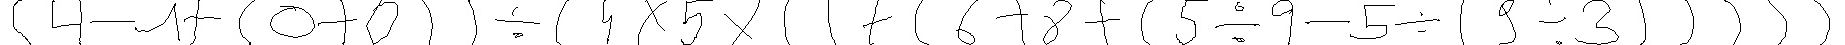

(4+(7-1+0*1/4))*(1+6+6)*(2+6-(6-2/6)-(1-6/(7+(2-5*7)))) [2, 2, 15, 7, 5, 7, 5, 2, 9, 11, 9, 7, 11, 7, 2, 23, 20, 18, 20, 18, 15, 20, 20, -1, 36, 26, 28, 26, 36, 31, 31, 28, 33, 31, 33, 31, 23, 39, 39, 36, 41, 39, 44, 44, 41, 47, 47, 44, 49, 47, 49, 47, 44, 39, 36] [None, 4, 10, None, 7, 6, 1, 6, 0, 0, 1, 0, 4, None, None, 130, None, 1, 7, 6, 13, 6, None, 390, None, 2, 8, 6, 3, None, 6, 5, 2, 1, 6, None, 3, None, 1, 0, 6, 1, None, 7, 7, None, 2, 0, 5, 35, 7, None, None, None, None] 390


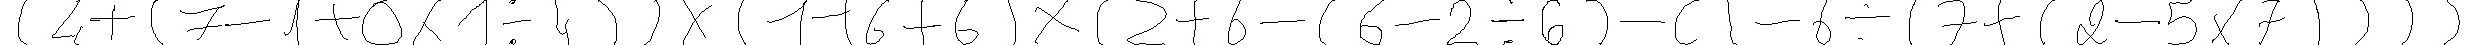

In [35]:
for i in range(1, 6):
    print(i, '='*60)
    dataset = [x for x in split2dataset['test'] if x['eval'] == i]
    for _ in range(10):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']), sample['head'], sample['res_all'], sample['res'])
        display(img)

# 4. Generate fewshot dataset

In [8]:
fewshot_concepts = list('abcde')
op2precedence.update({'a': 2, 'b': 2, 'c': 3, 'd': 3, 'e': 4})
op2arity.update({'a': 2, 'b': 2, 'c': 2, 'd': 2, 'e': 2})
functions = [lambda x,y: max(x, y), lambda x,y: min(x, y), lambda x,y: math.ceil((x+y)/2), 
             lambda x,y: max(0, (x*y)-(x+y)), lambda x,y: x**y if y < 10 else None]
programs = [Program(f) for f in functions]
SYM2PROG.update(dict(zip(fewshot_concepts, functions)))

In [9]:
random.seed(12306)
max_op = 20
max_train_op = 10

for i, fs in enumerate(fewshot_concepts):
    if i != 3:
        continue
    train_exprs = []
    val_exprs = []
    test_exprs = []
    n_test = 10
    n_val = 10
    
    op_list = ['+', '-', '*', '/', fs]
    
    # generate symbolic expression
    for n_op in range(max_op + 1):
        n_train = 20 if n_op == 1 else 10
        if n_op > max_train_op:
            n_train = 0
        expressions = generate_expression(n_op, 1000, max_value=max_value_train)
        expressions = [x for x in expressions if fs in x[0]]

        if n_train > 0:
            train_exprs.append(expressions[:n_train])
        val_exprs.append(expressions[:min(n_val, n_train)] + expressions[n_train:n_train+n_val])
        test_exprs.append(expressions[:n_train + n_test])

        expressions = generate_expression(n_op, 1000, 
                              min_value=max_value_train+1, max_value=max_value_test, non_zero_res=True)
        expressions = [x for x in expressions if fs in x[0]]
        val_exprs[-1].extend(expressions[:n_val])
        test_exprs[-1].extend(expressions[:n_test])

        print(n_op, len(train_exprs[-1]) if n_train > 0 else 0, len(val_exprs[-1]), len(test_exprs[-1]))

    split2exprs = {'train': train_exprs, 'val': val_exprs, 'test': test_exprs}
    print([(k, sum([len(x) for x in v])) for k, v in split2exprs.items()])
    
    # generate handwritten expression
    split2dataset = {}
    for split in splits:
        sym_set = split2sym[split]
        exprs = split2exprs[split]
        dataset = []
        idx = 0
        for n_op, expr_list in enumerate(exprs):
            n_instance = 1
            if split == 'val':
                n_instance *= 0.1
            for e in expr_list:
                for _ in range(int(math.ceil(n_instance))):
                    img_paths = generate_img_paths(e[0], sym_set)
                    sample = {'id': '%s_%08d'%(split, idx), 'img_paths':img_paths, 
                          'expr': e[0], 'head': e[1], 'res': e[2], 'res_all': e[3]}
                    idx += 1
                    dataset.append(sample)
        split2dataset[split] = dataset
        print(split, len(dataset))
    
    # generate evaluation flag
    train_exprs = {x['expr'] for x in split2dataset['train']}
    max_len_train = max([len(x) for x in train_exprs])
    print(max_len_train)
    for split in ['val', 'test']:
        dataset = split2dataset[split]
        for sample in dataset:
            expr = sample['expr']
            if expr in train_exprs:
                evaluation = 1
            elif len(expr) <= max_len_train:
                max_value = max([x for x in sample['res_all'] if x is not None])
                if max_value <= max_value_train:
                    evaluation = 2
                else:
                    evaluation = 3
            else:
                max_value = max([x for x in sample['res_all'] if x is not None])
                if max_value <= max_value_train:
                    evaluation = 4
                else:
                    evaluation = 5
            sample['eval'] = evaluation
    
    # save
    for split in splits:
        json.dump(split2dataset[split], open('fewshot_%d_expr_%s.json'%(i, split), 'w'))

0 0 0 0
1 20 20 30


 24%|██▍       | 243/1000 [00:00<00:00, 2426.28it/s]

2 10 30 30


  0%|          | 0/1000 [00:00<?, ?it/s]

3 10 30 30


  0%|          | 0/1000 [00:00<?, ?it/s]

4 10 30 30


  0%|          | 0/1000 [00:00<?, ?it/s]

5 10 30 30


  0%|          | 0/1000 [00:00<?, ?it/s]

6 10 30 30


  0%|          | 0/1000 [00:00<?, ?it/s]

7 10 30 30


100%|██████████| 1000/1000 [00:00<00:00, 6035.63it/s]


8 10 30 30


 53%|█████▎    | 527/1000 [00:00<00:00, 5266.85it/s]

9 10 30 30


 43%|████▎     | 434/1000 [00:00<00:00, 4311.61it/s]

10 10 30 30


 52%|█████▏    | 516/1000 [00:00<00:00, 5151.43it/s]

11 0 20 20


 34%|███▍      | 345/1000 [00:00<00:00, 3443.71it/s]

12 0 20 20


 35%|███▍      | 347/1000 [00:00<00:00, 3457.33it/s]

13 0 20 20


 27%|██▋       | 270/1000 [00:00<00:00, 2690.95it/s]

14 0 20 20


 22%|██▏       | 221/1000 [00:00<00:00, 2209.36it/s]

15 0 20 20


 19%|█▉        | 189/1000 [00:00<00:00, 1884.00it/s]

16 0 20 20


 19%|█▉        | 191/1000 [00:00<00:00, 1906.99it/s]

17 0 20 20


 17%|█▋        | 167/1000 [00:00<00:00, 1653.20it/s]

18 0 20 20


 15%|█▍        | 148/1000 [00:00<00:00, 1477.68it/s]

19 0 20 20


100%|██████████| 1000/1000 [00:01<00:00, 713.42it/s]


20 0 20 20
[('train', 110), ('val', 490), ('test', 500)]
train 110
val 490
test 500
33


[(1, 22.0), (2, 21.8), (3, 20.8), (4, 18.2), (5, 17.2)]
['8*9d(6*5d2)-((9-6)*3d(6*4)+3d3)', '(2+(1-4))d(7d7*6/1*8)', '(7*6-4+1)d(4*(6/2)-3)', '2/(9d7d5)', '9d(4+5*4)/(7*7d3)*(8/(8*8))', '6d(4*7d(2*(8d2)))', '(2+(9-2))d(6*9)', '9d9*(1*4)', '9*(8*(2*8))d8', '1d5+(3d2*3d7-(3-1/6))*(4*9*(5/5))']
33
train 110 79
[('(', 226), (')', 226), ('*', 88), ('+', 95), ('-', 112), ('/', 99), ('0', 68), ('1', 66), ('2', 70), ('3', 65), ('4', 69), ('5', 65), ('6', 68), ('7', 66), ('8', 59), ('9', 74), ('d', 166)]
[('(', 226), (')', 226), ('*', 88), ('+', 95), ('-', 112), ('/', 99), ('0', 68), ('1', 66), ('2', 70), ('3', 65), ('4', 69), ('5', 65), ('6', 68), ('7', 66), ('8', 59), ('9', 74), ('d', 62)]
(7/(9d(4*1))+9d0)*2 [12, 2, 12, 5, 5, 2, 8, 8, 5, 8, 8, 5, 17, 14, 12, 14, 12, -1, 17] [None, 7, 1, None, 9, 23, None, 4, 4, 1, None, None, 1, 9, 0, 0, None, 2, 2] 2


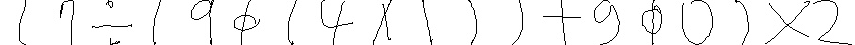

(0+(8-2)d2)*9 [2, 2, 11, 5, 5, 8, 5, 5, 2, 8, 2, -1, 11] [None, 0, 4, None, 8, 6, 2, None, 4, 2, None, 36, 9] 36


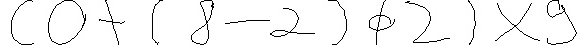

(0+(8-2)d2)*9 [2, 2, 11, 5, 5, 8, 5, 5, 2, 8, 2, -1, 11] [None, 0, 4, None, 8, 6, 2, None, 4, 2, None, 36, 9] 36


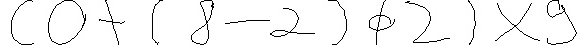

9+0/(9*4)*((8+(0-1+9))d0) [1, -1, 3, 9, 6, 6, 3, 6, 6, 1, 22, 13, 13, 22, 18, 16, 18, 16, 13, 18, 18, 13, 9, 22, 22] [9, 9, 0, 0, None, 9, 36, 4, None, 0, None, None, 8, 17, None, 0, 0, 1, 9, 9, None, None, 0, 0, None] 9


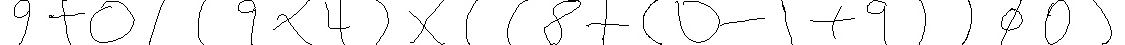

5d0-7d2 [1, 3, 1, -1, 5, 3, 5] [5, 0, 0, 0, 7, 5, 2] 0


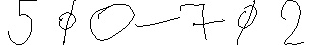

val 490 8231
[('(', 2081), (')', 2081), ('*', 930), ('+', 1084), ('-', 868), ('/', 767), ('0', 445), ('1', 507), ('2', 535), ('3', 519), ('4', 535), ('5', 530), ('6', 565), ('7', 536), ('8', 514), ('9', 544), ('d', 1091)]
[('(', 714), (')', 717), ('*', 162), ('+', 1084), ('-', 868), ('/', 43), ('0', 345), ('1', 507), ('2', 535), ('3', 519), ('4', 369), ('5', 177), ('6', 155), ('7', 145), ('8', 153), ('9', 186), ('d', 4)]
(9d4-9)/6+6*2 [4, 2, 4, 2, 7, 4, 4, 9, 7, -1, 11, 9, 11] [None, 9, 23, 4, 14, 9, None, 3, 6, 15, 6, 12, 2] 15


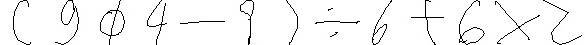

1*(1*(9/(7/7)*3)d(6/(3d7))) [1, -1, 16, 4, 16, 13, 7, 13, 10, 10, 7, 10, 10, 4, 13, 13, 1, 19, 19, 16, 22, 22, 19, 22, 22, 19, 16] [1, 0, None, 1, 27, None, 9, 9, None, 7, 1, 7, None, 27, 3, None, 0, None, 6, 1, None, 3, 11, 7, None, None, None] 0


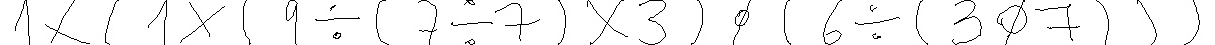

1+3+(8+9)+(8/7*((4+4)d6)d(2/9*3)+(3-2-(1+1d7))) [1, 3, 1, 9, 6, 6, 3, 6, 6, -1, 32, 12, 14, 12, 24, 21, 18, 18, 21, 18, 18, 14, 21, 21, 32, 29, 27, 29, 27, 24, 29, 29, 9, 37, 35, 37, 35, 32, 40, 40, 37, 42, 40, 42, 40, 37, 32] [1, 4, 3, 21, None, 8, 17, 9, None, 154, None, 8, 2, 7, 68, None, None, 4, 8, 4, None, 34, 6, None, 133, None, 2, 1, 9, 3, 3, None, 133, None, 3, 1, 2, 0, None, 1, 1, 1, 0, 7, None, None, None] 154


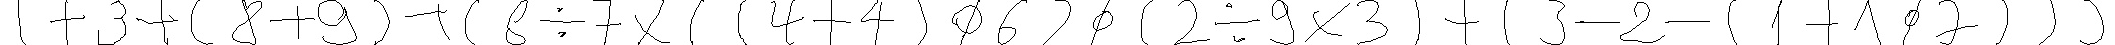

(4+(1-8)d9)d((4-(0+5)d3)/2) [2, 2, 11, 5, 5, 8, 5, 5, 2, 8, 2, -1, 24, 15, 15, 24, 18, 18, 21, 18, 18, 15, 21, 15, 11, 24, 24] [None, 4, 4, None, 1, 0, 8, None, 0, 9, None, 0, None, None, 4, 0, None, 0, 5, 5, None, 7, 3, None, 0, 2, None] 0


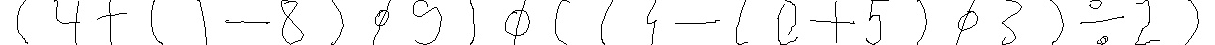

0d8 [1, -1, 1] [0, 0, 8] 0


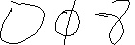

test 500 8231
[('(', 2081), (')', 2081), ('*', 930), ('+', 1084), ('-', 868), ('/', 767), ('0', 446), ('1', 511), ('2', 536), ('3', 521), ('4', 538), ('5', 533), ('6', 567), ('7', 537), ('8', 515), ('9', 546), ('d', 1101)]
[('(', 2081), (')', 2081), ('*', 651), ('+', 1084), ('-', 868), ('/', 174), ('0', 446), ('1', 511), ('2', 536), ('3', 521), ('4', 538), ('5', 533), ('6', 567), ('7', 537), ('8', 515), ('9', 546), ('d', 17)]
8d6d(7+(0+6/7+1)+2) [1, 3, 1, -1, 16, 6, 16, 13, 9, 13, 11, 9, 11, 6, 13, 13, 3, 16, 16] [8, 34, 6, 329, None, 7, 9, None, 0, 1, 6, 1, 7, 2, 1, None, 11, 2, None] 329


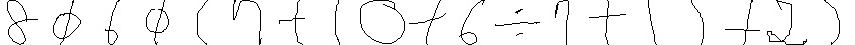

4d8 [1, -1, 1] [4, 20, 8] 20


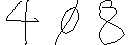

4d((3+7)d2+1-1)-4-(6+1+5d2)+1d(8/5)d(0d8/6d(0*9/5)) [1, 15, 12, 5, 5, 8, 5, 5, 10, 8, 12, 10, 1, 12, 12, 17, 15, 27, 22, 20, 22, 20, 17, 24, 22, 24, 22, -1, 29, 35, 32, 32, 29, 32, 32, 27, 42, 38, 40, 38, 42, 40, 35, 47, 45, 47, 45, 42, 47, 47, 42] [4, 20, None, None, 3, 10, 7, None, 8, 2, 9, 1, 8, 1, None, 16, 4, 6, None, 6, 7, 1, 10, 5, 3, 2, None, 6, 1, 0, None, 8, 2, 5, None, 0, None, 0, 0, 8, 0, 6, 0, None, 0, 0, 9, 0, 5, None, None] 6


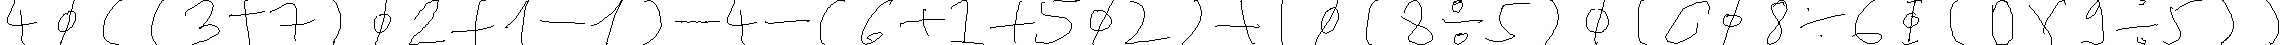

(0+7)*(2*4+(5+3)d6) [2, 2, 5, 2, 2, -1, 10, 8, 10, 8, 5, 13, 13, 16, 13, 13, 10, 16, 10] [None, 0, 7, 7, None, 294, None, 2, 8, 4, 42, None, 5, 8, 3, None, 34, 6, None] 294


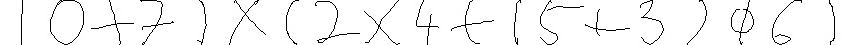

(0d5/(6d8/2)-(3d2-8d(6*0))d(8+5))d2+((2+8)*0+7)d(6/8*1) [12, 2, 4, 2, 12, 9, 7, 9, 7, 4, 9, 9, 33, 17, 15, 17, 15, 26, 19, 17, 22, 22, 19, 22, 22, 17, 12, 29, 29, 26, 29, 29, 12, 35, 33, -1, 44, 39, 39, 42, 39, 39, 44, 42, 47, 44, 44, 35, 52, 50, 52, 50, 47, 52, 52] [None, 0, 0, 5, 0, None, 6, 34, 8, 17, 2, None, 0, None, 3, 1, 2, 1, 8, 0, None, 6, 0, 0, None, None, 0, None, 8, 13, 5, None, None, 0, 2, 0, None, None, 2, 10, 8, None, 0, 0, 7, 7, None, 0, None, 6, 1, 8, 1, 1, None] 0


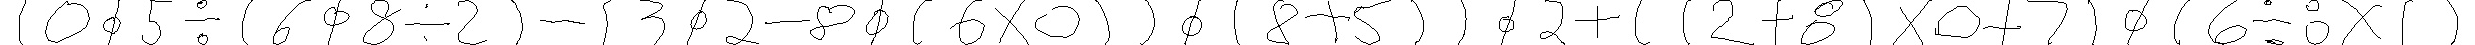

In [10]:
counts = sorted(Counter([x['eval'] for x in split2dataset['test']]).items())
total_count = sum([c for _, c in counts])
counts = [(k, round(v/total_count*100, 2)) for k, v in counts]
print(counts)
print(list({x['expr'] for x in split2dataset['test'] if x['eval'] == 3})[:10])
train_exprs = {x['expr'] for x in split2dataset['train']}
max_len_train = max([len(x) for x in train_exprs])
print(max_len_train)

# Visualize data
import numpy as np
for split in splits:
    dataset = split2dataset[split]
    print(split, len(dataset), np.max([x['res'] for x in dataset]))
    all_symbols = [(x, y) for sample in dataset for x, y in zip(sample['img_paths'], sample['expr'])]
    print(sorted(Counter([x[1] for x in all_symbols]).items()))
    print(sorted(Counter([x[1] for x in set(all_symbols)]).items()))
    for _ in range(5):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']), sample['head'], sample['res_all'], sample['res'])
        display(img)